
Import Libraries and Check CUDA Availability
---



In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ast
import torch.utils.data as data
from collections import defaultdict, Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Configuration and Label Mapping
---





In [29]:
# Training parameters
num_classes = 36
num_sensors = 5
sequence_length = 10
batch_size = 32
train_loop_enable =1

# Label mapping
label_map = {i * 10 + j: index for index, (i, j) in enumerate(((i, j) for i in range(1, 10) for j in range(1, 5)))}
index_to_label = {index: label for label, index in label_map.items()}

def label_to_index(labels):
    return torch.tensor([label_map[label.item()] for label in labels])

def label_to_index_int(labels):
    return label_map[label.item()]

def index_to_label_func(index):
    return index_to_label[index]

print(label_map)

{11: 0, 12: 1, 13: 2, 14: 3, 21: 4, 22: 5, 23: 6, 24: 7, 31: 8, 32: 9, 33: 10, 34: 11, 41: 12, 42: 13, 43: 14, 44: 15, 51: 16, 52: 17, 53: 18, 54: 19, 61: 20, 62: 21, 63: 22, 64: 23, 71: 24, 72: 25, 73: 26, 74: 27, 81: 28, 82: 29, 83: 30, 84: 31, 91: 32, 92: 33, 93: 34, 94: 35}



Import and Visualize Dataset
---



Kích thước của x_train: torch.Size([26846, 5, 10])
Kích thước của y_train: torch.Size([26846])


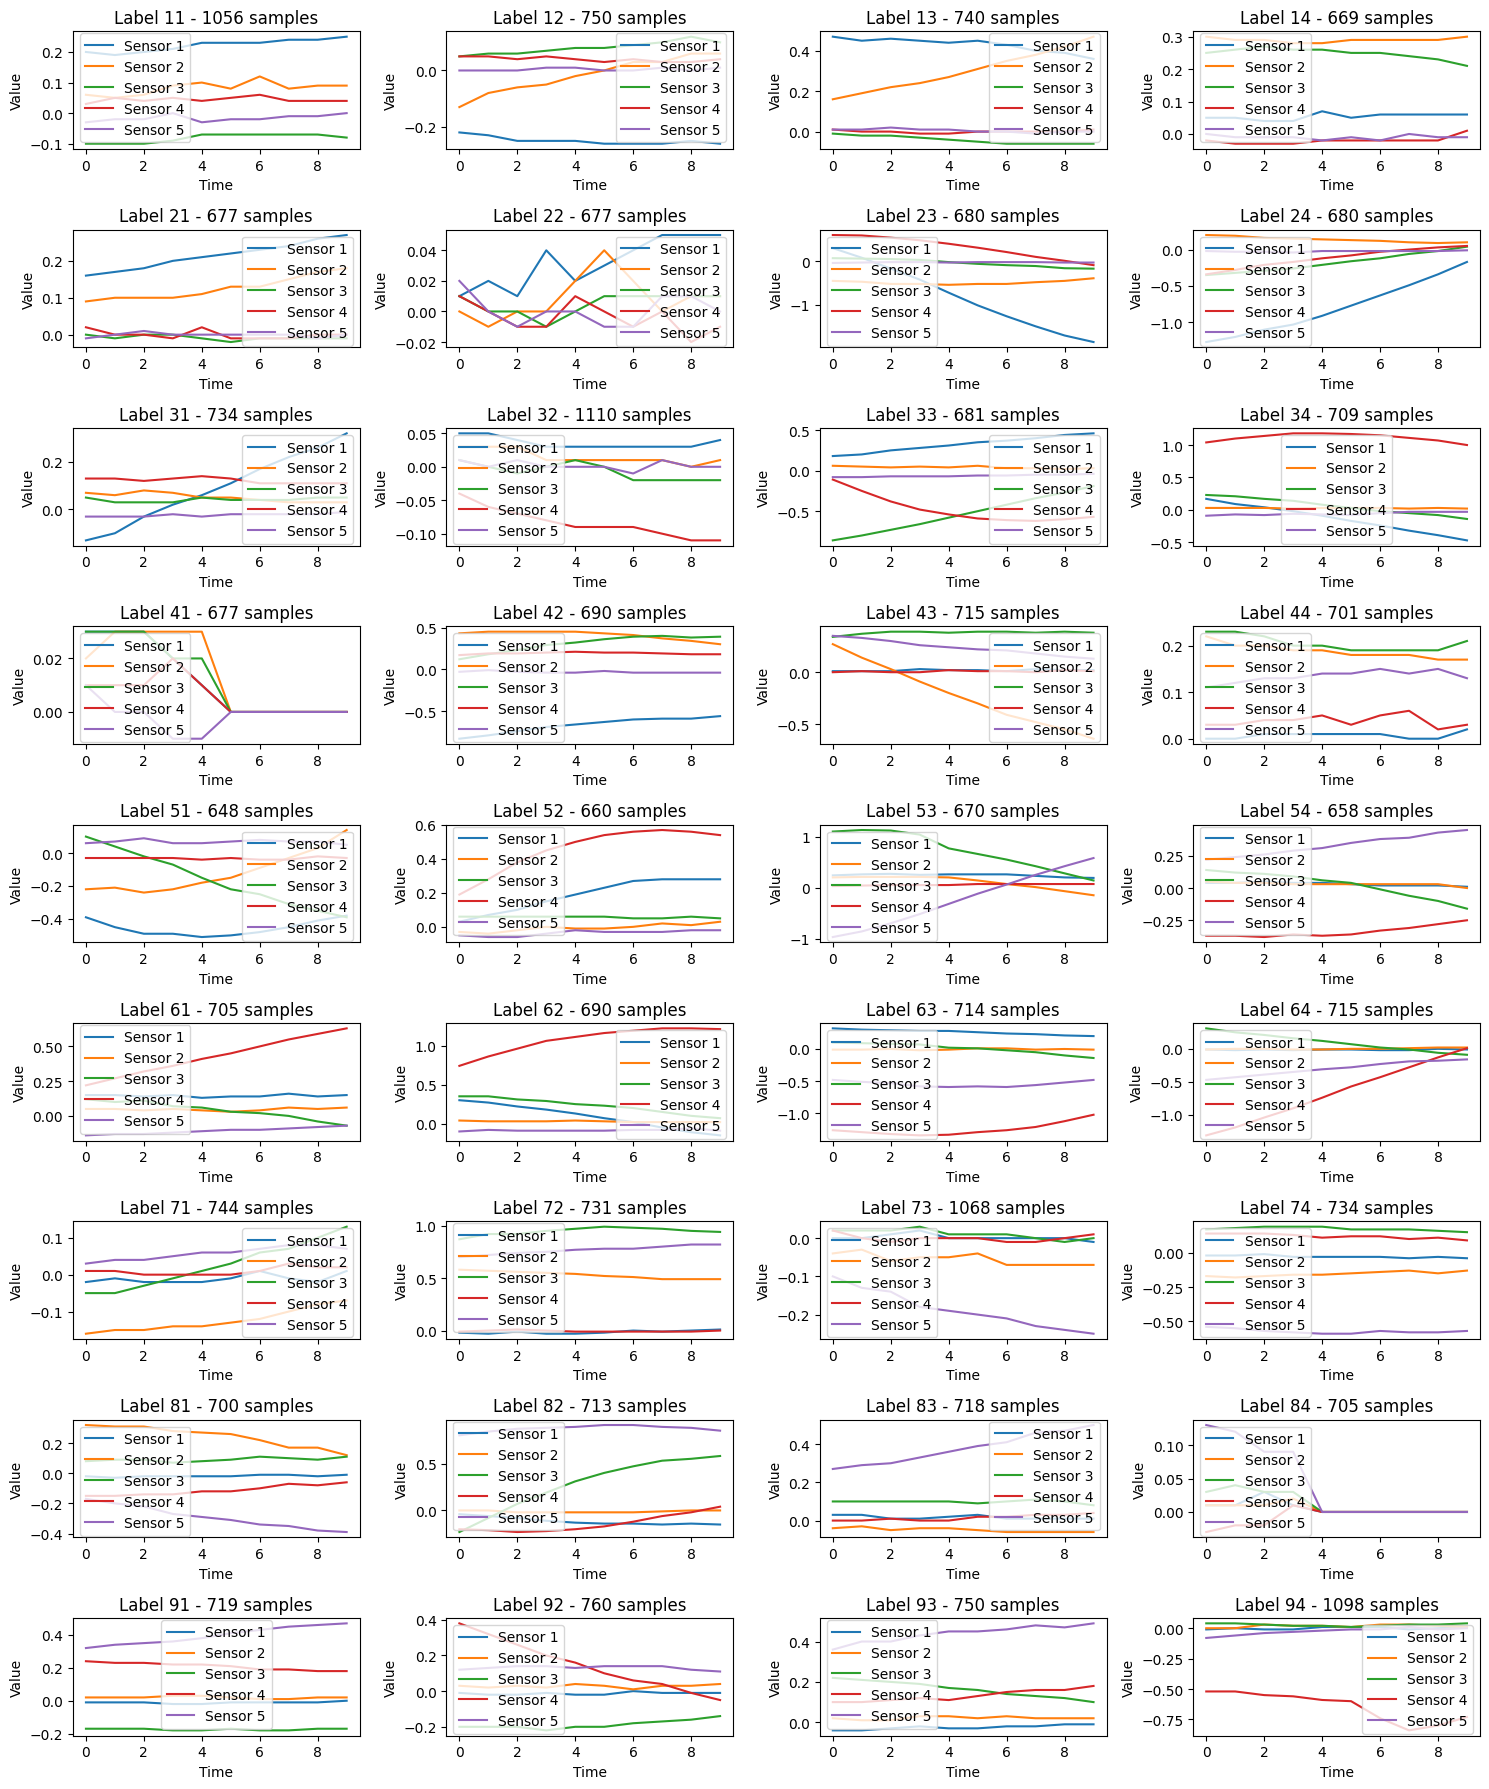

In [30]:
# Load data from CSV
df = pd.read_csv('Preprocessing_and_analysis_of_the_dataset/data_v2.csv')
x_data = df[['x1', 'x2', 'x3', 'x4', 'x5']]
y_data = df['y']

# Convert to PyTorch tensors
x_train = [torch.tensor([ast.literal_eval(val) for val in row.values], dtype=torch.float32) for _, row in x_data.iterrows()]
X_train = torch.stack(x_train).to(device)
y_train = torch.tensor(y_data.values, dtype=torch.long).to(device)

print("Kích thước của x_train:", X_train.shape)
print("Kích thước của y_train:", y_train.shape)

# Visualize data
unique_labels = torch.unique(y_train)
samples_per_label = {label.item(): (X_train[(y_train == label).nonzero(as_tuple=True)[0][np.random.randint(len((y_train == label).nonzero(as_tuple=True)[0]))]].cpu().numpy(), len((y_train == label).nonzero(as_tuple=True)[0])) for label in unique_labels}

plt.figure(figsize=(15, 18))
for idx, (label, (data, count)) in enumerate(samples_per_label.items()):
    plt.subplot(9, 4, idx + 1)
    for i in range(num_sensors):
        plt.plot(data[i], label=f"Sensor {i+1}")
    plt.title(f'Label {label} - {count} samples')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
plt.tight_layout()
plt.show()

T-SNE Visualization
---



In [31]:
# import pandas as pd
# import ast
# import torch
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# # Move data to CPU for t-SNE
# X_train_cpu = X_train.to('cpu')
# y_train_cpu = y_train.to('cpu')

# # Flatten the X_train tensor for t-SNE
# X_flat = X_train_cpu.reshape(X_train_cpu.shape[0], -1)

# # Perform t-SNE using scikit-learn
# tsne = TSNE(n_components=2,  random_state=42, init='pca', learning_rate='auto')
# X_tsne = tsne.fit_transform(X_flat)

# # Plot the t-SNE results
# plt.figure(figsize=(8, 6))  # Thay đổi kích thước của hình để tạo không gian cho chú thích


# # Define a list of 40 distinct colors
# # Sử dụng palette màu cơ bản của Matplotlib
# colors1 = plt.cm.tab20b.colors
# colors2 = plt.cm.tab20c.colors
# colors = colors1 + colors2

# # Ensure the length of the colors list matches the number of unique labels
# colors = colors[:len(unique_labels)]

# for label in unique_labels:
#     indices = (y_train_cpu == label).nonzero(as_tuple=True)[0]
#     plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'Label {label.item()}', alpha=0.7, s=10, color=colors[label_to_index_int(label)])

# # Plot the t-SNE results
# plt.figure(figsize=(80, 60))  # Thay đổi kích thước của hình để tạo không gian cho chú thích


# # Define a list of 40 distinct colors
# # Sử dụng palette màu cơ bản của Matplotlib
# colors1 = plt.cm.tab20b.colors
# colors2 = plt.cm.tab20c.colors
# colors = colors1 + colors2

# # Ensure the length of the colors list matches the number of unique labels
# colors = colors[:len(unique_labels)]

# for label in unique_labels:
#     indices = (y_train_cpu == label).nonzero(as_tuple=True)[0]
#     plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'Label {label.item()}', alpha=1, s=1000, color=colors[label_to_index_int(label)])

# plt.title('t-SNE Visualization of the Dataset',fontsize = 100)
# # plt.xlabel('t-SNE Component 1',fontsize = 70)
# # plt.ylabel('t-SNE Component 2',fontsize = 70)

# # Di chuyển phần chú thích ra bên ngoài hình chính và chia thành hai cột
# plt.legend(bbox_to_anchor=(1.05, 1),fontsize = 100,loc='upper left', ncol=2)

# # Lưu ảnh với định dạng PNG và cắt bớt khoảng trắng
# plt.savefig('t_sne_plot.png', bbox_inches='tight')

# plt.show()


Splitting dataset
---




In [32]:
import torch.utils.data as data
# Split dataset
train_size = int(0.8 * len(X_train))
test_size = len(X_train) - train_size
train_dataset, test_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, y_train), [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_size, test_size)

21476 5370


Define Model
---

In [33]:
# Define model
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 128, 3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, 3, padding=1)
        self.conv3 = nn.Conv1d(256, 512, 3, padding=1)
        self.conv4 = nn.Conv1d(512, 512, 3, padding=1)
        self.conv5 = nn.Conv1d(512, 1024, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.batch_norm5 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.3)
        self.padding = nn.ConstantPad1d((0, 1), 0)
        self.maxpool = nn.MaxPool1d(2, stride=1)
        self.fc = nn.Linear(1024 * sequence_length, num_classes)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

class CNNLSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = CNN1D(input_size, num_classes)
        self.lstm = LSTMModel(1024, 1024, 2, num_classes, 0.3)

    def forward(self, x):
        x = torch.relu(self.cnn.batch_norm1(self.cnn.conv1(x)))
        x = torch.relu(self.cnn.batch_norm2(self.cnn.conv2(x)))
        x = torch.relu(self.cnn.batch_norm3(self.cnn.conv3(x)))
        x = torch.relu(self.cnn.batch_norm5(self.cnn.conv5(x)))
        x = self.cnn.padding(x)
        x = self.cnn.maxpool(x)
        x = self.cnn.dropout(x)
        x = x.transpose(1, 2).contiguous().view(x.size(0), -1, 1024)
        h0 = torch.zeros(2, x.size(0), 1024).to(x.device)
        c0 = torch.zeros(2, x.size(0), 1024).to(x.device)
        x, _ = self.lstm.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.lstm.fc(x)
        # print(x)
        x = self.lstm.relu(x)
        return x

model = CNNLSTM(num_sensors, num_classes).to(device)


Import Trained Model
---



In [34]:
# Load trained model
model_file_path = './model/my_model_v2.pth'
if os.path.isfile(model_file_path):
    model.load_state_dict(torch.load(model_file_path) if device == "cuda" else torch.load(model_file_path, map_location=torch.device('cpu')))
    print("Đã tải mô hình từ tệp tin đã lưu.")
else:
    print("Không tìm thấy tệp tin của mô hình.")

Không tìm thấy tệp tin của mô hình.


Define Training Parameters
---



In [35]:
# Training parameters
num_epochs = 100
learning_rate = 0.0001
weight_decay = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


Trainning phase
---



Epoch [1/100], Loss: 3.7489
Epoch [2/100], Loss: 1.9765
Epoch [3/100], Loss: 3.4621
Epoch [4/100], Loss: 2.6416
Epoch [5/100], Loss: 4.5709
Epoch [6/100], Loss: 2.8183
Epoch [7/100], Loss: 2.9037
Epoch [8/100], Loss: 2.3315
Epoch [9/100], Loss: 0.8775
Da luu model: ./model/my_model_v2.pth
Epoch [10/100], Loss: 0.8453
Epoch [11/100], Loss: 1.4371
Epoch [12/100], Loss: 0.8485
Epoch [13/100], Loss: 2.3630
Epoch [14/100], Loss: 1.8975
Epoch [15/100], Loss: 0.1967
Epoch [16/100], Loss: 1.9212
Epoch [17/100], Loss: 0.3470
Epoch [18/100], Loss: 1.4014
Epoch [19/100], Loss: 4.6892
Da luu model: ./model/my_model_v2.pth
Epoch [20/100], Loss: 0.4572
Epoch [21/100], Loss: 2.8764
Epoch [22/100], Loss: 0.5401
Epoch [23/100], Loss: 0.0188
Epoch [24/100], Loss: 1.5544
Epoch [25/100], Loss: 1.1286
Epoch [26/100], Loss: 0.4117
Epoch [27/100], Loss: 1.1074
Epoch [28/100], Loss: 0.0660
Epoch [29/100], Loss: 2.9580
Da luu model: ./model/my_model_v2.pth
Epoch [30/100], Loss: 0.2356
Epoch [31/100], Loss: 0.4

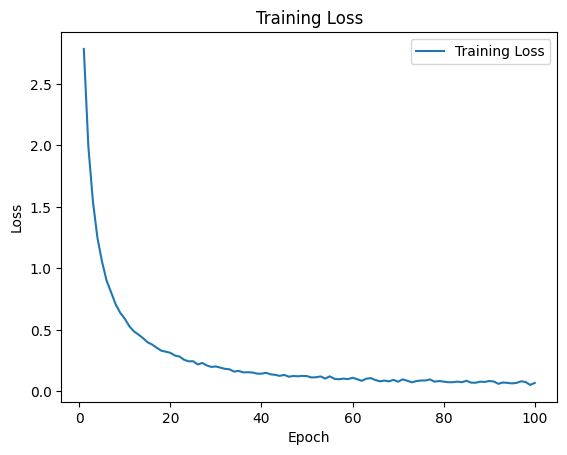

In [36]:
if train_loop_enable:
    train_losses = []
    num_samples = len(train_loader.dataset)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels
            labels = label_to_index(labels).to(device)
    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        train_losses.append(running_loss / (num_samples / batch_size))
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), model_file_path)
            print(f'Da luu model: {model_file_path}')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    print('Training finished!')
    
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



Result evaluation
---



Accuracy: 92.03%
Label 92:
  Precision: 0.92
  Recall: 0.87
  F1 Score: 0.89
Label 14:
  Precision: 0.91
  Recall: 0.96
  F1 Score: 0.93
Label 74:
  Precision: 0.90
  Recall: 0.96
  F1 Score: 0.93
Label 42:
  Precision: 0.98
  Recall: 0.94
  F1 Score: 0.96
Label 64:
  Precision: 0.91
  Recall: 0.93
  F1 Score: 0.92
Label 53:
  Precision: 0.98
  Recall: 0.91
  F1 Score: 0.94
Label 71:
  Precision: 0.88
  Recall: 0.94
  F1 Score: 0.91
Label 93:
  Precision: 0.88
  Recall: 0.95
  F1 Score: 0.92
Label 91:
  Precision: 0.94
  Recall: 0.96
  F1 Score: 0.95
Label 83:
  Precision: 0.85
  Recall: 0.98
  F1 Score: 0.91
Label 13:
  Precision: 0.91
  Recall: 0.94
  F1 Score: 0.93
Label 82:
  Precision: 0.97
  Recall: 0.93
  F1 Score: 0.95
Label 54:
  Precision: 1.00
  Recall: 0.95
  F1 Score: 0.98
Label 34:
  Precision: 0.84
  Recall: 0.93
  F1 Score: 0.88
Label 11:
  Precision: 0.92
  Recall: 0.92
  F1 Score: 0.92
Label 31:
  Precision: 0.84
  Recall: 0.95
  F1 Score: 0.89
Label 44:
  Precision: 

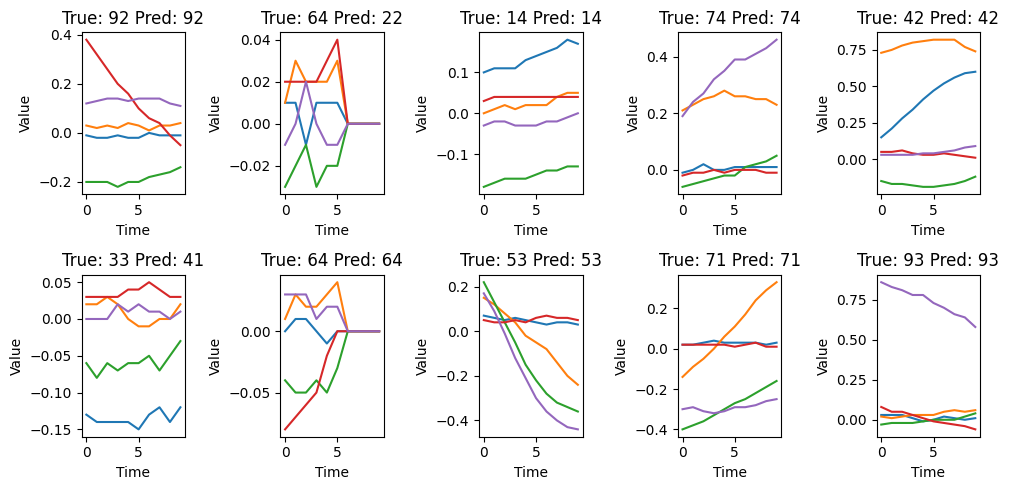

Predictions saved to ./result compare/v2/predictions.csv


In [37]:
import torch.utils.data as data
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize variables
TP, number_sample = 0, 0
wrong_predictions = defaultdict(lambda: {"predicted_labels": [], "count": 0})
TP_dict, FP_dict, FN_dict, total_samples_per_label = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)
all_true_labels, all_predicted_labels = [], []

# Evaluate model
model.eval()
with torch.no_grad():
    for input_sequence, label in test_loader:
        output = model(input_sequence.to(device))
        predicted_class = torch.argmax(output, dim=1)
        predicted_labels = [index_to_label_func(pred.item()) for pred in predicted_class]

        number_sample += len(label)
        for i, true_label in enumerate(label):
            true_label = true_label.item()
            total_samples_per_label[true_label] += 1
            predicted_label = predicted_labels[i]

            all_true_labels.append(true_label)
            all_predicted_labels.append(predicted_label)

            if true_label == predicted_label:
                TP += 1
                TP_dict[true_label] += 1
            else:
                FP_dict[predicted_label] += 1
                FN_dict[true_label] += 1
                wrong_predictions[true_label]["predicted_labels"].append(predicted_label)
                wrong_predictions[true_label]["count"] += 1

# Calculate accuracy
accuracy = TP / number_sample * 100
print(f'Accuracy: {accuracy:.2f}%')

# Calculate and print precision, recall, and F1 score for each label
precision_dict, recall_dict, f1_dict = {}, {}, {}
for label in TP_dict.keys():
    TP = TP_dict[label]
    FP = FP_dict[label]
    FN = FN_dict[label]
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    precision_dict[label] = precision
    recall_dict[label] = recall
    f1_dict[label] = f1_score

    print(f"Label {label}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1_score:.2f}")

# Calculate mean macro F1 score
all_labels = set(TP_dict.keys()).union(set(FP_dict.keys())).union(set(FN_dict.keys()))
macro_f1_score = sum(
    (2 * (TP_dict[label] / (TP_dict[label] + FP_dict[label]) if (TP_dict[label] + FP_dict[label]) > 0 else 0) *
     (TP_dict[label] / (TP_dict[label] + FN_dict[label]) if (TP_dict[label] + FN_dict[label]) > 0 else 0)) /
    ((TP_dict[label] / (TP_dict[label] + FP_dict[label]) if (TP_dict[label] + FP_dict[label]) > 0 else 0) +
     (TP_dict[label] / (TP_dict[label] + FN_dict[label]) if (TP_dict[label] + FN_dict[label]) > 0 else 0)) if
    ((TP_dict[label] / (TP_dict[label] + FP_dict[label]) if (TP_dict[label] + FP_dict[label]) > 0 else 0) +
     (TP_dict[label] / (TP_dict[label] + FN_dict[label]) if (TP_dict[label] + FN_dict[label]) > 0 else 0)) > 0 else 0
    for label in all_labels
) / len(all_labels)
print('Mean macro F1 score', macro_f1_score)

# Calculate Kappa
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Tính tần suất thỏa thuận quan sát được (p_o)
total_samples = np.sum(conf_matrix)
p_o = np.trace(conf_matrix) / total_samples

# Tính tần suất thỏa thuận mong đợi (p_e)
sum_true = np.sum(conf_matrix, axis=1)
sum_pred = np.sum(conf_matrix, axis=0)
p_e = np.sum(sum_true * sum_pred) / (total_samples ** 2)

# Tính chỉ số Kappa
kappa = (p_o - p_e) / (1 - p_e)
print("Chỉ số Kappa:", kappa)

# Print labels with the most wrong predictions
print("Labels with most wrong predictions:")
sorted_wrong_predictions = sorted(wrong_predictions.items(), key=lambda x: x[1]["count"], reverse=True)
for label, details in sorted_wrong_predictions[:5]:
    print(f"  Label {label}:")
    for predicted_label, count in Counter(details["predicted_labels"]).items():
        print(f"    Predicted as {predicted_label}: {count} times")

# Save wrong predictions to file
wrong_prediction_file = './result compare/v2/wrong_predictions.txt'
with open(wrong_prediction_file, 'w') as file:
    for label, details in sorted_wrong_predictions:
        file.write(f"Label {label} ({details['count']} wrong predictions):\n")
        for predicted_label, count in Counter(details["predicted_labels"]).items():
            file.write(f"  Predicted as {predicted_label}: {count} times\n")
print(f"Wrong predictions saved to {wrong_prediction_file}")

# Plot predictions
sample_inputs, sample_labels = next(iter(test_loader))
sample_outputs = model(sample_inputs.to(device))
_, sample_predictions = torch.max(sample_outputs, 1)
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(sample_inputs[i].cpu().numpy().T)
    plt.title(f'True: {sample_labels[i].item()} Pred: {index_to_label_func(sample_predictions[i].cpu().item())}')
    plt.xlabel('Time')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

# Save predictions to file
predictions_file = './result compare/v2/predictions.csv'
with open(predictions_file, 'w') as file:
    file.write('Index,True Label,Predicted Label\n')
    for i, (inputs, label) in enumerate(test_loader):
        inputs, label = inputs.to(device), label.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for j in range(inputs.size(0)):
            file.write(f'{i * batch_size + j},{label[j].item()},{index_to_label_func(predicted[j].item())}\n')
print(f'Predictions saved to {predictions_file}')


Function for process testdata
---



In [12]:
# ______________________________Sec1____________________________________________
def calculate_area(signal, threshold=2.05):
    # Tính phần diện tích dưới đường cong và trục y=threshold
    diff_signal = signal - threshold

    # Tính diện tích sử dụng quy tắc hình thang
    area = torch.sum(torch.abs((diff_signal[:, :-1] + diff_signal[:, 1:]) / 2), dim=1)

    return area

def check_area(signals, threshold=2.05, area_threshold=1.5):
    # Tính diện tích cho từng sensor
    areas = calculate_area(signals, threshold)

    # # In ra diện tích của từng sensor
    # for i, area in enumerate(areas):
    #     print(f"Diện tích của sensor {i + 1}: {area.item()}")

    # Tính tổng diện tích của 5 sensor
    total_area = torch.sum(areas)
    # print(f"Tổng diện tích: {total_area.item()}")

    # Kiểm tra tổng diện tích có lớn hơn area_threshold không
    return total_area > area_threshold

# # Giả sử tín hiệu đầu vào dạng torch size (1,5,10)
# signals_list = [
#     [2.05,2.05,2.05,2.05,2.03,2.04,2.04,2.04,2.05,2.05],
#     [2.05,2.05,2.06,2.06,2.06,2.08,2.07,2.07,2.07,2.07],
#     [2.05,2.04,2.03,2.05,2.04,2.04,2.04,2.05,2.05,2.05],
#     [2.04,2.04,2.04,2.05,2.07,2.05,2.05,2.05,2.06,2.05],
#     [2.07,2.06,2.05,2.05,2.04,2.06,2.05,2.06,2.06,2.06]
# ]

# # Chuyển đổi signals_list thành tensor PyTorch
# signals = torch.tensor(signals_list, dtype=torch.float32)
# print(signals)
# # Kiểm tra diện tích
# result = check_area(signals)
# print(f"Kết quả: {result}")
# ______________________________Sec2____________________________________________
# Define the area
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]
def string_labels_to_int(labels):
    """Convert a list of string labels to integer labels."""
    return [int(label) for label in labels]
def label_to_coords(label, area):
    """Convert label to coordinates in the custom grid system."""
    if label == 0:
        return None
    for i, row in enumerate(area):
        if label in row:
            row_index = i
            col_index = row.index(label)
            return (row_index, col_index)
    return None

def is_adjacent(coord1, coord2):
    """Check if two coordinates are adjacent in the 3x3 grid."""
    if coord1 is None or coord2 is None:
        return False
    row_diff = abs(coord1[0] - coord2[0])
    col_diff = abs(coord1[1] - coord2[1])
    return row_diff <= 1 and col_diff <= 1

def correct_labels_old(labels, area):
    """Correct the sequence of labels if they are not adjacent."""
    corrected_labels = []
    previous_coords = None
    i=0
    for label in labels:
        current_coords = label_to_coords(label, area)
        if label != 0 and previous_coords is not None and not is_adjacent(previous_coords, current_coords):
            corrected_labels.append(corrected_labels[-1])  # Use the last valid non-zero label
        else:
            corrected_labels.append(label)
        if label != 0:
            previous_coords = label_to_coords(corrected_labels[-1],area)
        i+=1

    return corrected_labels
def correct_labels(labels, area):
    """Correct the sequence of labels if they are not adjacent."""
    corrected_labels = labels.copy()
    previous_coords = None

    # First pass: fix non-adjacent labels
    for i, label in enumerate(labels):
        if label == 0:
            continue

        current_coords = label_to_coords(label, area)
        if previous_coords and not is_adjacent(previous_coords, current_coords):
            corrected_labels[i] = corrected_labels[i-1]
        previous_coords = current_coords if label != 0 else previous_coords
    # print(corrected_labels)
    # Second pass: handle zeros
    n = len(labels)
    i = 0
    # print(i)
    while i < n:
        if labels[i] == 0:
            # Find the start and end of the zero block
            start = i
            while i < n and labels[i] == 0:
                i += 1
            end = i - 1
            # print('bat dau 0 ket thuc: ',start,end)
            # print(corrected_labels)
            # Check the labels at the boundaries
            if start > 0 and end < n - 1:
                j=start-1
                k=end+1
                if labels[j] != labels[k]:
                    if labels[j] == labels[k+1]:
                        corrected_labels[k] = 0
                        continue
                    if labels[j-1] == labels[k]:
                        corrected_labels[j] = 0
                        continue
                    corrected_labels[j] = 0
                    corrected_labels[k] = 0
                    # print('thay',start-1,'-',end+1)
                    # Expand the zero block if necessary
                    j-=1
                    k+=1
                    while j > 0 and k < n - 1 and corrected_labels[j] != corrected_labels[k]:
                        if labels[j] == labels[k+1]:
                            corrected_labels[k] = 0
                            break
                        if labels[j-1] == labels[k]:
                            corrected_labels[j] = 0
                            break
                        corrected_labels[j] = 0
                        corrected_labels[k] = 0
                        j -= 1
                        k += 1
        i += 1

    return corrected_labels
def most_frequent_in_sliding_window(arr, k, s, padding):
    from collections import Counter

    # Kiểm tra các tham số đầu vào
    if not arr or k <= 0 or s <= 0:
        return []

    result = []
    n = len(arr)

    for i in range(0, n, s):
        # Tạo cửa sổ với padding nếu vượt quá giới hạn của danh sách
        if i<k//2:
            window = arr[0:i + k- k//2]
        else:
            window = arr[i-k//2:i + k- k//2]
            window = arr[i-k//2:i + k- k//2]
            if len(window) < k:
                if padding==None:
                    continue
                else:
                    window += [padding] * (k - len(window))

        if all(x == 0 for x in window):
            result.append(0)
        else:
            window=[x for x in window if x != 0]
            counter = Counter(window)
    
            # Tìm tần suất lớn nhất
            max_freq = max(counter.values())
    
            # Tìm phần tử xuất hiện nhiều nhất với tần suất max_freq, ưu tiên phần tử xuất hiện trước
            for num in window:
                if counter[num] == max_freq:
                    result.append(num)
                    break
        
    return result

def repeat_labels(labels, repeat_count=10, last_count=None):
    """Repeat each label in the list a specified number of times.

    Args:
    labels (list): List of labels to be repeated.
    repeat_count (int): Number of times to repeat each label.
    last_count (int): Number of times to repeat the last label. If None, use repeat_count for the last label as well.

    Returns:
    list: List of repeated labels.
    """
    if last_count is None:
        last_count = repeat_count

    repeated_labels = []
    for i, label in enumerate(labels):
        if i == len(labels) - 1:
            repeated_labels.extend([label] * last_count)
        else:
            repeated_labels.extend([label] * repeat_count)

    return repeated_labels

def process_labels(correct_labels):
    """Process labels by replacing 0 with the last non-zero label."""
    processed_labels = []
    waiting_zero = 0

    for label in correct_labels:
        if label == 0:
            if len(processed_labels) > 0 and processed_labels[-1] != 0:
                processed_labels.append(processed_labels[-1])
            else:
                waiting_zero += 1
        else:
            if waiting_zero > 0:
                processed_labels.extend([label] * (waiting_zero + 1))
                waiting_zero = 0
            else:
                processed_labels.append(label)
    return processed_labels
# # Example usage:
# corrected_labels = ['11', '12', '24', '33', 0, '44', '55', '66']  # Example corrected labels
# repeated_labels = repeat_labels(corrected_labels, repeat_count=10)
# print(repeated_labels)

# ______________________________Sec3____________________________________________
# Khu vực chứa các nhãn
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]

# Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area
def label_to_xy(label, area):
    for i, row in enumerate(area):
        for j, cell in enumerate(row):
            if cell == label:
                return j - 2.5, 2.5 - i  # Return (x, y) coordinates

# Hàm tính toán tọa độ trung bình của các điểm
def average_coordinates(coords):
    avg_x = sum(coord[0] for coord in coords) / len(coords)
    avg_y = sum(coord[1] for coord in coords) / len(coords)
    return avg_x, avg_y

# Hàm tính toán tọa độ trung bình của mỗi nhóm k điểm
def compute_group_coordinates(labels, area, k):
    new_coordinates = []
    for i in range(0, len(labels), k):  # Lặp qua các nhóm k nhãn
        coords = [label_to_xy(label, area) for label in labels[i:i+k]]  # Chuyển đổi nhãn thành tọa độ
        avg_coord = average_coordinates(coords)  # Tính toán tọa độ trung bình
        new_coordinates.append(avg_coord)  # Thêm tọa độ trung bình vào danh sách mới
    return new_coordinates

# Hàm vẽ đường đi từ danh sách tọa độ
def plot_path(coordinates):
    # Tách tọa độ x và y từ danh sách tọa độ
    x_coords, y_coords = zip(*coordinates)
    
    # Vẽ đường đi
    plt.plot(x_coords, y_coords, marker='o', linestyle='-')
    
    # Đặt tiêu đề và nhãn trục
    plt.title('Đường đi')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    
    # Hiển thị đồ thị
    plt.grid(True)
    plt.show()
    
# Hàm vẽ đường đi từ danh sách tọa độ
def mul_plot_path(coordinates):
    if not coordinates:
        print("Danh sách tọa độ trống!")
        return
    
    # Kiểm tra xem có một hoặc nhiều xâu tọa độ
    if isinstance(coordinates[0], tuple):
        coordinates = [coordinates]  # Nếu chỉ có một xâu tọa độ, chuyển đổi thành danh sách có một phần tử
        
    # Lặp qua từng xâu tọa độ và vẽ
    for i, coord_set in enumerate(coordinates):
        # Tách tọa độ x và y từ danh sách tọa độ
        x_coords, y_coords = zip(*coord_set)
        
        # Vẽ đường đi với màu khác nhau cho mỗi xâu tọa độ
        plt.plot(x_coords, y_coords, marker='o', linestyle='-', alpha=0.5, label=f'Path {i+1}')
    
    # Đặt tiêu đề và nhãn trục
    plt.title('Đường đi')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    
    # Hiển thị đồ thị và chú thích
    plt.legend()
    plt.grid(True)
    plt.axis([-3,3,-3,3])
    plt.show()

Import test data
---



In [36]:
# Đọc dữ liệu từ file CSV vào DataFrame
df = pd.read_csv('Preprocessing_and_analysis_of_the_dataset/data_test_data.csv')

# Chọn chỉ một dòng từ DataFrame
x_sc_list=[]
y_sc_list=[]
for row_index in range(df.shape[0]):
    selected_row = df.iloc[row_index]
    
    # Lấy dữ liệu của các cột 'x' và 'y' từ hàng đã chọn
    x_values = [ast.literal_eval(selected_row[col]) for col in df.columns if col != 'y']
    y_values = [ast.literal_eval(selected_row['y'])]
    # Chuyển đổi dữ liệu thành tensors PyTorch
    X_test = torch.tensor([x_values], dtype=torch.float32)
    Y_test = torch.tensor([y_values], dtype=torch.float32)
    # Kiểm tra kích thước của tensors
    print("Kích thước của X_test của kịch bản ",row_index+1,':', X_test.shape)
    print("Kích thước của Y_test của kịch bản ",row_index+1,':', Y_test.shape)
    x_sc_list.append(X_test)
    y_sc_list.append(Y_test)




Kích thước của X_test của kịch bản  1 : torch.Size([1, 5, 2073])
Kích thước của Y_test của kịch bản  1 : torch.Size([1, 1, 2073])
Kích thước của X_test của kịch bản  2 : torch.Size([1, 5, 1743])
Kích thước của Y_test của kịch bản  2 : torch.Size([1, 1, 1743])
Kích thước của X_test của kịch bản  3 : torch.Size([1, 5, 3367])
Kích thước của Y_test của kịch bản  3 : torch.Size([1, 1, 3367])
Kích thước của X_test của kịch bản  4 : torch.Size([1, 5, 3877])
Kích thước của Y_test của kịch bản  4 : torch.Size([1, 1, 3877])


Predict and visual testdata (All scenarios)
---



kich ban  1

Độ chính xác tốt nhất:  0.9372889532079113 -----Best threshold 1.1
kappa score 0.9198332708138549
Khoảng cách trung bình: 0.14551191003571434


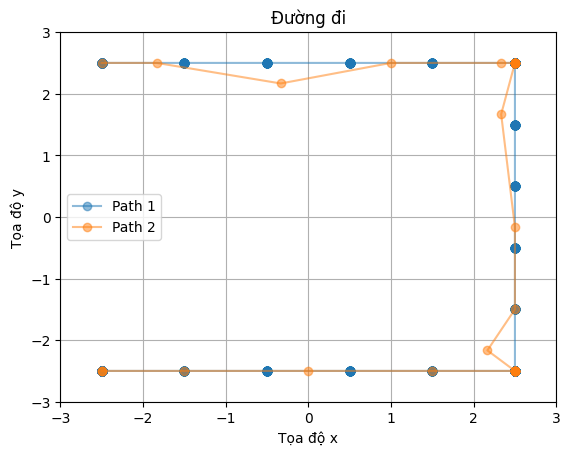

kich ban  2

Độ chính xác tốt nhất:  0.8973034997131383 -----Best threshold 1.7
kappa score 0.8697761254769182
Khoảng cách trung bình: 0.22365183533414387


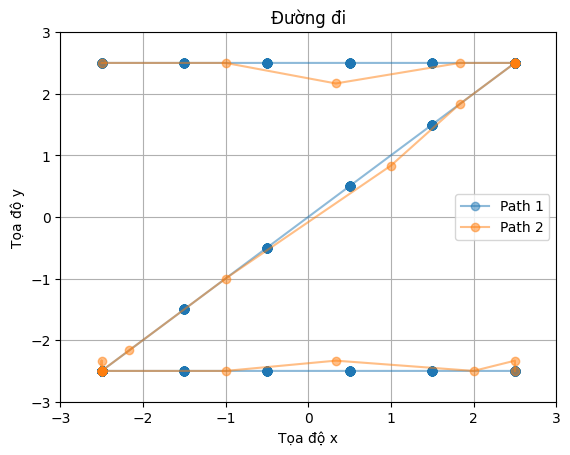

kich ban  3

Độ chính xác tốt nhất:  0.8577368577368577 -----Best threshold 2.2
kappa score 0.8338437139223047
Khoảng cách trung bình: 0.31519089909433456


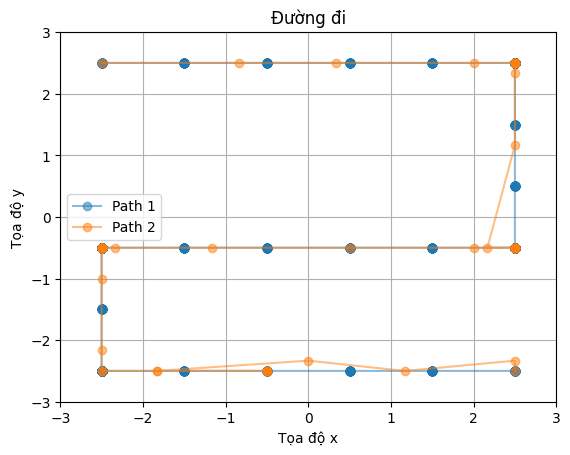

kich ban  4

Độ chính xác tốt nhất:  0.6401857106009802 -----Best threshold 4.8
kappa score 0.5915576274158593
Khoảng cách trung bình: 0.6424084368635857


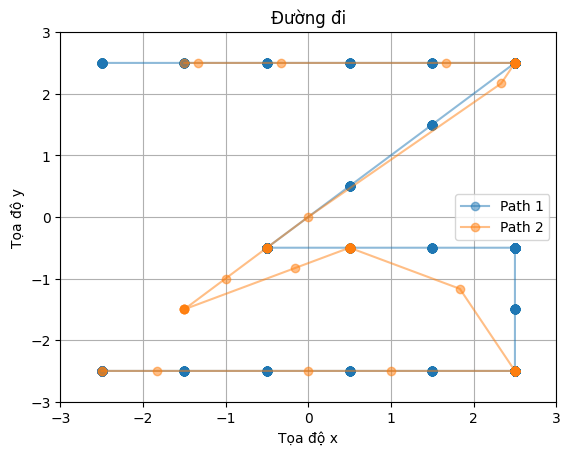

In [37]:
import torch
import numpy as np
from sklearn.metrics import cohen_kappa_score

window_size = 10

# Chọn kịch bản
for sc_index in range(len(y_sc_list)):
        print('kich ban ',sc_index+1)
        X_test=x_sc_list[sc_index]
        Y_test=y_sc_list[sc_index]
        
        # Số lượng cửa sổ có thể tạo ra từ dữ liệu test
        num_windows = X_test.shape[2] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
        window_residual=X_test.shape[2] % window_size
        if window_residual:
            num_windows+=1
        else:
            window_residual=window_size
        
        max_result=0
        for thre_i in [1.1,1.7,2.2,4.8]:
            # Lặp qua từng mẫu trong X_test và dự đoán nhãn cho từng cửa sổ
            predictions = []
            for sample in X_test:
                sample_windows = []
                for i in range(num_windows):
                    window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)  # Chọn cửa sổ và thêm chiều batch_size
                    check = check_area(window[0],area_threshold=thre_i)
                    # check = motion_detection_2d_tensor(window[0])
                    if check:
                        with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
                            output = model(window.to(device))  # Dự đoán nhãn cho cửa sổ hiện tại
            
                        # Xử lý đầu ra
                        predicted_class = torch.argmax(output, dim=1).item()
                        predicted_label = index_to_label_func(predicted_class)
                    else:
                        predicted_label=0
                    sample_windows.append(predicted_label)
                predictions.append(sample_windows)
            corrected_labels = correct_labels_old(predictions[0], area)
            processed_labels = process_labels(corrected_labels)
            repeated_labels = repeat_labels(processed_labels, repeat_count=10,last_count=window_residual)
            int_list = [int(x) for x in Y_test[0][0].tolist()]

            true_case=0
            for i in range(len(repeated_labels)):
                if int_list[i]==repeated_labels[i]:
                    true_case+=1
            if true_case/len(int_list)>max_result:
                max_result=true_case/len(int_list)
                best_threshold=thre_i
            
        print("\nĐộ chính xác tốt nhất: ",max_result,'-----Best threshold',best_threshold)
        predictions = []
        for sample in X_test:
            sample_windows = []
            for i in range(num_windows):
                window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)
                check = check_area(window[0],area_threshold=best_threshold)
                if check:
                    with torch.no_grad():
                        output = model(window.to(device))
                    predicted_class = torch.argmax(output, dim=1).item()
                    predicted_label = index_to_label_func(predicted_class)
                else:
                    predicted_label=0
                sample_windows.append(predicted_label)
            predictions.append(sample_windows)
        corrected_labels = correct_labels_old(predictions[0], area)
        processed_labels = process_labels(corrected_labels)
        repeated_labels = repeat_labels(processed_labels, repeat_count=10,last_count=window_residual)
        int_list = [int(x) for x in Y_test[0][0].tolist()]

        y_true_np = np.array(int_list)
        y_pred_np = np.array(repeated_labels)
    
        kappa = cohen_kappa_score(y_true_np, y_pred_np)
        print('kappa score',kappa)

        # Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
        # y_true_xy = compute_group_coordinates(most_frequent_in_sliding_window(int_list, k=60, s=60,padding=0), area, k=1)
        y_true_xy = compute_group_coordinates(int_list, area, k=1)
        y_pred_xy = compute_group_coordinates(repeated_labels, area,k=60)
        repeated_y_pred_xy=repeat_labels(y_pred_xy, repeat_count=60,last_count=window_residual)
        
        # Tính khoảng cách trung bình (Mean Distance)
        vertical_distance = 0.5  # Khoảng cách theo chiều dọc (m)
        horizontal_distance = 0.5  # Khoảng cách theo chiều ngang (m)
        
        # Tính khoảng cách Euclidean giữa các cặp tọa độ và tính khoảng cách trung bình
        distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, repeated_y_pred_xy)]
        mean_distance = np.mean(distances)
        
        print("Khoảng cách trung bình:", mean_distance)
        
        # Vẽ đường đi từ danh sách tọa độ
        mul_plot_path([y_true_xy,y_pred_xy])

Predict label testdata (one selected scenarios)
---



In [ ]:
window_size = 10

# Chọn kịch bản
sc_index=2
X_test=x_sc_list[sc_index]
Y_test=y_sc_list[sc_index]

# Số lượng cửa sổ có thể tạo ra từ dữ liệu test
num_windows = X_test.shape[2] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
window_residual=X_test.shape[2] % window_size
if window_residual:
    num_windows+=1
else:
    window_residual=window_size

max_result=0
for thre_i in range(50):
    # Lặp qua từng mẫu trong X_test và dự đoán nhãn cho từng cửa sổ
    predictions = []
    for sample in X_test:
        sample_windows = []
        for i in range(num_windows):
            window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)  # Chọn cửa sổ và thêm chiều batch_size
            check = check_area(window[0],area_threshold=thre_i/10.0)
            # check = motion_detection_2d_tensor(window[0])
            if check:
                with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
                    output = model(window.to(device))  # Dự đoán nhãn cho cửa sổ hiện tại
    
                # Xử lý đầu ra
                predicted_class = torch.argmax(output, dim=1).item()
                predicted_label = index_to_label_func(predicted_class)
            else:
                predicted_label=0
            sample_windows.append(predicted_label)
        predictions.append(sample_windows)
    # print(predictions)
    corrected_labels = correct_labels_old(predictions[0], area)
    # print(corrected_labels)
    
    # k=6
    # s=1
    # # corrected_labels = most_frequent_in_sliding_window(corrected_labels, k, s,0)
    # # print(corrected_labels)
    
    processed_labels = process_labels(corrected_labels)
    # print(processed_labels)
    
    repeated_labels = repeat_labels(processed_labels, repeat_count=10,last_count=window_residual)
    # print(repeated_labels)
    
    int_list = [int(x) for x in Y_test[0][0].tolist()]
    
    # # Print elements separated by commas
    # for num in repeated_labels:
    #     print("{:<{width}}".format(num, width=3), end=",")
    # print()
    
    # # Convert tensor to list of integers
    # for num in int_list:
    #     print("{:<{width}}".format(num, width=3), end=",")
    
    true_case=0
    for i in range(len(repeated_labels)):
        if int_list[i]==repeated_labels[i]:
            true_case+=1
    if true_case/len(int_list)>max_result:
        max_result=true_case/len(int_list)
        best_threshold=thre_i/10.0
print("\nĐộ chính xác tốt nhất: ",max_result,'-----Best threshold',best_threshold)


Visaulize Predicted testdata  (one selected scenarios)
---

In [ ]:
predictions = []
for sample in X_test:
    sample_windows = []
    for i in range(num_windows):
        window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)
        check = check_area(window[0],area_threshold=best_threshold)
        if check:
            with torch.no_grad():
                output = model(window.to(device))
            predicted_class = torch.argmax(output, dim=1).item()
            predicted_label = index_to_label_func(predicted_class)
        else:
            predicted_label=0
        sample_windows.append(predicted_label)
    predictions.append(sample_windows)
corrected_labels = correct_labels_old(predictions[0], area)
processed_labels = process_labels(corrected_labels)
repeated_labels = repeat_labels(processed_labels, repeat_count=10,last_count=window_residual)
int_list = [int(x) for x in Y_test[0][0].tolist()]

# Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
y_true_xy = compute_group_coordinates(int_list, area, k=1)
y_pred_xy = compute_group_coordinates(repeated_labels, area,k=60)
repeated_y_pred_xy=repeat_labels(y_pred_xy, repeat_count=60,last_count=window_residual)

y_true_np = np.array(int_list)
y_pred_np = np.array(repeated_labels)

kappa = cohen_kappa_score(y_true_np, y_pred_np)
print('kappa score',kappa)

# Tính khoảng cách trung bình (Mean Distance)
vertical_distance = 0.5  # Khoảng cách theo chiều dọc (m)
horizontal_distance = 0.5  # Khoảng cách theo chiều ngang (m)

# Tính khoảng cách Euclidean giữa các cặp tọa độ và tính khoảng cách trung bình
distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, repeated_y_pred_xy)]
mean_distance = np.mean(distances)

print("Khoảng cách trung bình:", mean_distance)

# Vẽ đường đi từ danh sách tọa độ
mul_plot_path([y_true_xy,y_pred_xy])

Raw1
---

kich ban  1

Độ chính xác tốt nhất:  0.9372889532079113 -----Best threshold 1.1
kappa score 0.9198332708138549
Khoảng cách trung bình: 0.14551191003571434


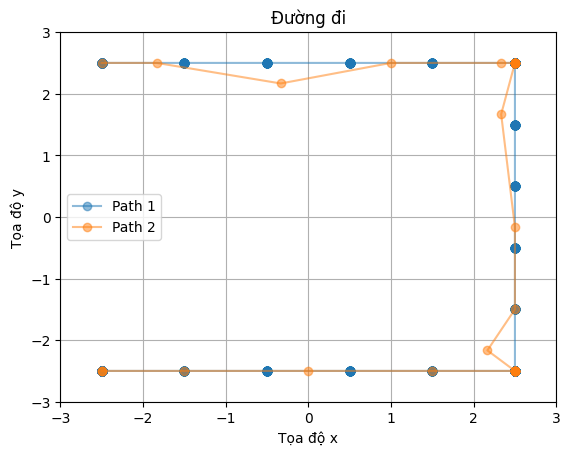

kich ban  2

Độ chính xác tốt nhất:  0.8973034997131383 -----Best threshold 1.7
kappa score 0.8697761254769182
Khoảng cách trung bình: 0.22365183533414387


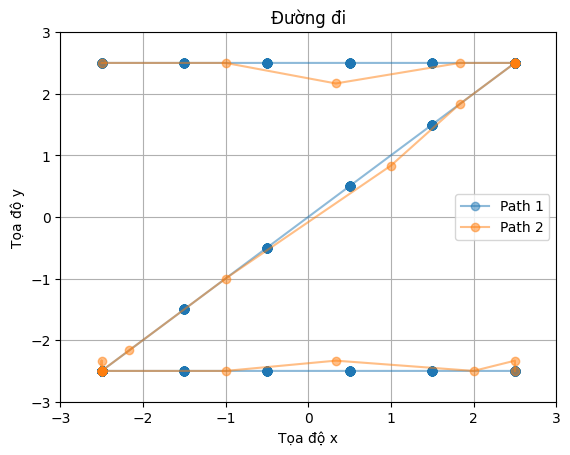

kich ban  3

Độ chính xác tốt nhất:  0.9367389367389367 -----Best threshold 3.2
kappa score 0.9248375431740464
Khoảng cách trung bình: 0.14146677059018187


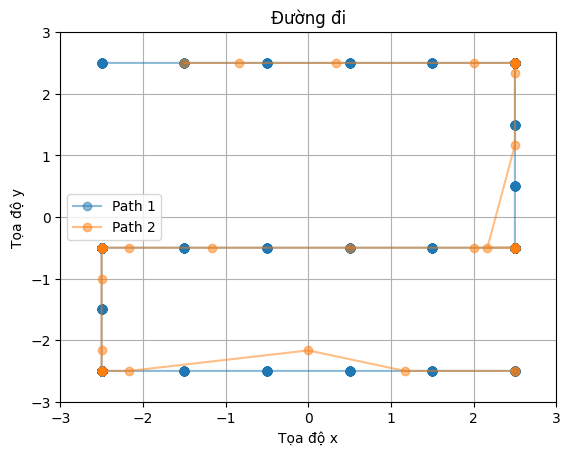

kich ban  4

Độ chính xác tốt nhất:  0.6401857106009802 -----Best threshold 4.8
kappa score 0.5915576274158593
Khoảng cách trung bình: 0.6424084368635857


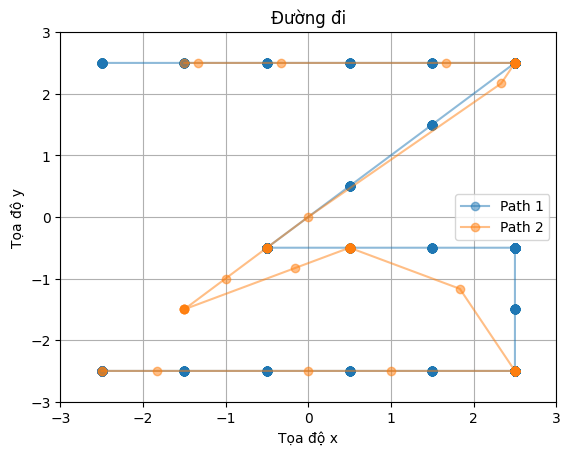

In [27]:
import torch
import numpy as np
from sklearn.metrics import cohen_kappa_score

window_size = 10

# Chọn kịch bản
for sc_index in range(len(y_sc_list)):
        print('kich ban ',sc_index+1)
        X_test=x_sc_list[sc_index]
        Y_test=y_sc_list[sc_index]
        
        # Số lượng cửa sổ có thể tạo ra từ dữ liệu test
        num_windows = X_test.shape[2] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
        window_residual=X_test.shape[2] % window_size
        if window_residual:
            num_windows+=1
        else:
            window_residual=window_size
        
        max_result=0
        for thre_i in range(50):
            # Lặp qua từng mẫu trong X_test và dự đoán nhãn cho từng cửa sổ
            predictions = []
            for sample in X_test:
                sample_windows = []
                for i in range(num_windows):
                    window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)  # Chọn cửa sổ và thêm chiều batch_size
                    check = check_area(window[0],area_threshold=thre_i/10.0)
                    # check = motion_detection_2d_tensor(window[0])
                    if check:
                        with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
                            output = model(window.to(device))  # Dự đoán nhãn cho cửa sổ hiện tại
            
                        # Xử lý đầu ra
                        predicted_class = torch.argmax(output, dim=1).item()
                        predicted_label = index_to_label_func(predicted_class)
                    else:
                        predicted_label=0
                    sample_windows.append(predicted_label)
                predictions.append(sample_windows)
            corrected_labels = correct_labels_old(predictions[0], area)
            processed_labels = process_labels(corrected_labels)
            repeated_labels = repeat_labels(processed_labels, repeat_count=10,last_count=window_residual)
            int_list = [int(x) for x in Y_test[0][0].tolist()]

            true_case=0
            for i in range(len(repeated_labels)):
                if int_list[i]==repeated_labels[i]:
                    true_case+=1
            if true_case/len(int_list)>max_result:
                max_result=true_case/len(int_list)
                best_threshold=thre_i/10.0
            
        print("\nĐộ chính xác tốt nhất: ",max_result,'-----Best threshold',best_threshold)
        predictions = []
        for sample in X_test:
            sample_windows = []
            for i in range(num_windows):
                window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)
                check = check_area(window[0],area_threshold=best_threshold)
                if check:
                    with torch.no_grad():
                        output = model(window.to(device))
                    predicted_class = torch.argmax(output, dim=1).item()
                    predicted_label = index_to_label_func(predicted_class)
                else:
                    predicted_label=0
                sample_windows.append(predicted_label)
            predictions.append(sample_windows)
        corrected_labels = correct_labels_old(predictions[0], area)
        processed_labels = process_labels(corrected_labels)
        repeated_labels = repeat_labels(processed_labels, repeat_count=10,last_count=window_residual)
        int_list = [int(x) for x in Y_test[0][0].tolist()]

        y_true_np = np.array(int_list)
        y_pred_np = np.array(repeated_labels)
    
        kappa = cohen_kappa_score(y_true_np, y_pred_np)
        print('kappa score',kappa)

        # Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
        # y_true_xy = compute_group_coordinates(most_frequent_in_sliding_window(int_list, k=60, s=60,padding=0), area, k=1)
        y_true_xy = compute_group_coordinates(int_list, area, k=1)
        y_pred_xy = compute_group_coordinates(repeated_labels, area,k=60)
        repeated_y_pred_xy=repeat_labels(y_pred_xy, repeat_count=60,last_count=window_residual)
        
        # Tính khoảng cách trung bình (Mean Distance)
        vertical_distance = 0.5  # Khoảng cách theo chiều dọc (m)
        horizontal_distance = 0.5  # Khoảng cách theo chiều ngang (m)
        
        # Tính khoảng cách Euclidean giữa các cặp tọa độ và tính khoảng cách trung bình
        distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, repeated_y_pred_xy)]
        mean_distance = np.mean(distances)
        
        print("Khoảng cách trung bình:", mean_distance)
        
        # Vẽ đường đi từ danh sách tọa độ
        mul_plot_path([y_true_xy,y_pred_xy])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, medfilt

# Đọc file CSV gốc
file_path = 'result compare/v2/real_data.csv'
data = pd.read_csv(file_path)

# Hiển thị dữ liệu gốc
print("Dữ liệu gốc:")
print(data.head())

# Thiết kế bộ lọc thông thấp Butterworth
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Áp dụng bộ lọc trung vị
def median_filter(data, kernel_size=3):
    return medfilt(data, kernel_size)

# Thông số bộ lọc
cutoff = 0.01 # Giảm tần số cắt để lọc nhiều nhiễu hơn
fs = 1  # Tần số mẫu (giả định là 1, có thể điều chỉnh theo dữ liệu thực)
order = 6  # Tăng bậc của bộ lọc

# Áp dụng bộ lọc thông thấp và bộ lọc trung vị cho từng cột
filtered_data = pd.DataFrame()
for column in data.columns:
    # Áp dụng bộ lọc thông thấp
    low_passed = lowpass_filter(data[column], cutoff, fs, order)
    # Áp dụng bộ lọc trung vị
    filtered_data[column] = median_filter(low_passed, kernel_size=5)

# Hiển thị dữ liệu đã lọc
print("\nDữ liệu đã lọc:")
print(filtered_data.head())

# Vẽ đồ thị cho từng cột dữ liệu
for column in data.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(data[column], label=f'{column} gốc', alpha=0.7)
    plt.plot(filtered_data[column], label=f'{column} đã lọc', linewidth=2)
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị')
    plt.title(f'Bộ lọc thông thấp và trung vị cho {column}')
    plt.legend()
    plt.grid(True)
    plt.show()
# Lưu dữ liệu đã lọc vào file CSV mới
filtered_file_path = 'result compare/v2/filtered_real_data.csv'
filtered_data.to_csv(filtered_file_path, index=False)

print(f"\nDữ liệu đã lọc được lưu vào file: {filtered_file_path}")


In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Đọc file CSV gốc
file_path = 'result compare/v2/filtered_real_data.csv'
data = pd.read_csv(file_path)

# Tạo trục thời gian cho dữ liệu gốc (100Hz)
original_time = np.arange(0, len(data)) / 100.0

# Tạo trục thời gian mới (60Hz)
new_time = np.arange(0, original_time[-1], 1/60.0)

# Nội suy cho từng cột
interpolated_data = {}
for column in data.columns:
    interpolator = interp1d(original_time, data[column], kind='linear')
    interpolated_data[column] = interpolator(new_time)

# Tạo DataFrame mới từ dữ liệu đã nội suy
new_data = pd.DataFrame(interpolated_data)

# Lưu DataFrame mới thành file CSV
new_file_path = 'result compare/v2/real_data_60.csv'
new_data.to_csv(new_file_path, index=False)


In [ ]:
import pandas as pd
import numpy as np

# Đọc dữ liệu từ file CSV ban đầu
input_file = 'result compare/v2/real_data_60.csv'
data = pd.read_csv(input_file)


# Chuyển đổi dữ liệu thành các mảng của 10 timestep
new_data = {col: [] for col in data.columns}
num_rows = len(data)


# Xác định số lượng timestep
timesteps = num_rows


for start in range(0, num_rows, timesteps):
    end = start + timesteps
    if end <= num_rows:
        for col in data.columns:
            new_data[col].append(data[col].iloc[start:end].values.tolist())

# Tạo DataFrame mới từ dữ liệu đã chuyển đổi
new_df = pd.DataFrame(new_data)

# Ghi dữ liệu mới vào file CSV
output_file = 'result compare/v2/real_data_60_10.csv'
new_df.to_csv(output_file, index=False)


In [ ]:
# Đọc dữ liệu từ file CSV vào DataFrame
df = pd.read_csv('real_data_60_10.csv')

# Chọn chỉ một dòng từ DataFrame
x_sc_list=[]
for row_index in range(df.shape[0]):
    selected_row = df.iloc[row_index]
    
    # Lấy dữ liệu của các cột 'x' và 'y' từ hàng đã chọn
    x_values = [ast.literal_eval(selected_row[col]) for col in df.columns if col != 'y']
    # Chuyển đổi dữ liệu thành tensors PyTorch
    X_test = torch.tensor([x_values], dtype=torch.float32)
    # Kiểm tra kích thước của tensors
    print("Kích thước của X_test của kịch bản ",row_index+1,':', X_test.shape)
    x_sc_list.append(X_test)




In [ ]:
window_size = 10

# Chọn kịch bản
sc_index=0
X_test=x_sc_list[sc_index]

# Số lượng cửa sổ có thể tạo ra từ dữ liệu test
num_windows = X_test.shape[2] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
window_residual=X_test.shape[2] % window_size
if window_residual:
    num_windows+=1
else:
    window_residual=window_size

max_result=0

# Lặp qua từng mẫu trong X_test và dự đoán nhãn cho từng cửa sổ
predictions = []
for sample in X_test:
    sample_windows = []
    for i in range(num_windows):
        window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)  # Chọn cửa sổ và thêm chiều batch_size
        with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
            output = model(window.to(device))  # Dự đoán nhãn cho cửa sổ hiện tại

        # Xử lý đầu ra
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_label = index_to_label_func(predicted_class)
        sample_windows.append(predicted_label)
    predictions.append(sample_windows)
# print(predictions)
# corrected_labels = correct_labels_old(predictions[0], area)
# print(corrected_labels)

# k=6
# s=1
# # corrected_labels = most_frequent_in_sliding_window(corrected_labels, k, s,0)
# # print(corrected_labels)

# processed_labels = process_labels(corrected_labels)
# print(processed_labels)

repeated_labels = repeat_labels(predictions[0], repeat_count=17,last_count=window_residual)
# print(repeated_labels)



In [ ]:
import csv

# Lưu repeated_labels và int_list vào final_compare_pre.csv
with open('result compare/v2/final_compare_pre_re.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['repeated_labels'])
    for repeated_label in zip(repeated_labels):
        csvwriter.writerow([repeated_label])
print("Dữ liệu đã được lưu vào result compare/v2/final_compare_pre_re.csv")


In [ ]:
# Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
y_pred_xy = compute_group_coordinates(repeated_labels, area,k=60)
# repeated_y_pred_xy=repeat_labels(y_pred_xy, repeat_count=60,last_count=window_residual)

y_pred_np = np.array(repeated_labels)

# Vẽ đường đi từ danh sách tọa độ

mul_plot_path([y_pred_xy])

# Raw2
---



In [ ]:
import torch
import numpy as np
from sklearn.metrics import cohen_kappa_score

window_size = 10

# Chọn kịch bản
sc_index = 3
X_test = x_sc_list[sc_index]
Y_test = y_sc_list[sc_index]

# Số lượng cửa sổ có thể tạo ra từ dữ liệu test
num_windows = X_test.shape[2] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
window_residual = X_test.shape[2] % window_size
if window_residual:
    num_windows += 1
else:
    window_residual = window_size
print(num_windows)
model.eval()

max_result = 0
best_threshold = 0
max_result_=0
for thre_i in range(50):
    # Lặp qua từng mẫu trong X_test và dự đoán nhãn cho từng cửa sổ
    predictions = []
    for sample in X_test:
        sample_windows = []
        for i in range(num_windows):
            window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)  # Chọn cửa sổ và thêm chiều batch_size
            check = check_area(window[0], area_threshold = thre_i / 10.0)
            # check = motion_detection_2d_tensor(window[0])
            if check:
                with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
                    output = model(window.to(device))  # Dự đoán nhãn cho cửa sổ hiện tại
    
                # Xử lý đầu ra
                predicted_class = torch.argmax(output, dim=1).item()
                predicted_label = index_to_label_func(predicted_class)
            else:
                predicted_label = 0
            sample_windows.append(predicted_label)
        predictions.append(sample_windows)
    corrected_labels = correct_labels_old(predictions[0], area)
    processed_labels = process_labels(corrected_labels)
    repeated_labels = repeat_labels(processed_labels, repeat_count=10, last_count=window_residual)
    int_list = [int(x) for x in Y_test[0][0].tolist()]
    
    true_case = 0
    for i in range(len(repeated_labels)):
        if int_list[i] == repeated_labels[i]:
            true_case += 1
            
    # Tính chỉ số Kappa
    y_true_np = np.array(int_list)
    y_pred_np = np.array(repeated_labels)
    
    # Sử dụng hàm cohen_kappa_score để tính Kappa
    kappa = cohen_kappa_score(y_true_np, y_pred_np)
    if kappa > max_result:
        max_result = kappa
        max_result_=true_case/len(int_list)
        best_threshold = thre_i / 10.0

print("\nĐộ chính xác tốt nhất: ", max_result, '-----Best threshold', best_threshold,'--------',max_result_)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import cohen_kappa_score

window_size = 10

# Chọn kịch bản
sc_index = 3
X_test = x_sc_list[sc_index]
Y_test = y_sc_list[sc_index]

# Số lượng cửa sổ có thể tạo ra từ dữ liệu test
num_windows = X_test.shape[2] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
window_residual = X_test.shape[2] % window_size
if window_residual:
    num_windows += 1
else:
    window_residual = window_size
print(num_windows)
model.eval()

max_result = 6
best_threshold = 0
max_result_=0
max_result__=0
for thre_i in range(50):
    # Lặp qua từng mẫu trong X_test và dự đoán nhãn cho từng cửa sổ
    predictions = []
    for sample in X_test:
        sample_windows = []
        for i in range(num_windows):
            window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)  # Chọn cửa sổ và thêm chiều batch_size
            check = check_area(window[0], area_threshold = thre_i / 10.0)
            # check = motion_detection_2d_tensor(window[0])
            if check:
                with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
                    output = model(window.to(device))  # Dự đoán nhãn cho cửa sổ hiện tại
    
                # Xử lý đầu ra
                predicted_class = torch.argmax(output, dim=1).item()
                predicted_label = index_to_label_func(predicted_class)
            else:
                predicted_label = 0
            sample_windows.append(predicted_label)
        predictions.append(sample_windows)
    # print(predictions)
    corrected_labels = correct_labels_old(predictions[0], area)
    # print(corrected_labels)
    
    # k=6
    # s=1
    # # corrected_labels = most_frequent_in_sliding_window(corrected_labels, k, s,0)
    # # print(corrected_labels)
    
    processed_labels = process_labels(corrected_labels)
    # print(processed_labels)
    
    repeated_labels = repeat_labels(processed_labels, repeat_count=10, last_count=window_residual)
    # print(repeated_labels)
    
    int_list = [int(x) for x in Y_test[0][0].tolist()]
    
    # # Print elements separated by commas
    # for num in repeated_labels:
    #     print("{:<{width}}".format(num, width=3), end=",")
    # print()
    
    # # Convert tensor to list of integers
    # for num in int_list:
    #     print("{:<{width}}".format(num, width=3), end=",")
    
    true_case = 0
    for i in range(len(repeated_labels)):
        if int_list[i] == repeated_labels[i]:
            true_case += 1
            
    # Tính chỉ số Kappa
    y_true_np = np.array(int_list)
    y_pred_np = np.array(repeated_labels)
    
    # Sử dụng hàm cohen_kappa_score để tính Kappa
    kappa = cohen_kappa_score(y_true_np, y_pred_np)

    # Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area
    def label_to_xy(label, area):
        for i, row in enumerate(area):
            for j, cell in enumerate(row):
                if cell == label:
                    return j, i  # Return (x, y) coordinates
    
    # Hàm chuyển đổi từ danh sách nhãn sang danh sách tọa độ (x, y)
    def labels_to_xy(labels, area):
        return [label_to_xy(label, area) for label in labels]
    
    # Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
    y_true_xy = labels_to_xy(int_list, area)
    y_pred_xy = labels_to_xy(repeated_labels, area)
    
    
    # Tính khoảng cách trung bình (Mean Distance)
    vertical_distance = 0.5  # Khoảng cách theo chiều dọc (m)
    horizontal_distance = 0.5  # Khoảng cách theo chiều ngang (m)
    
    # Tính khoảng cách Euclidean giữa các cặp tọa độ và tính khoảng cách trung bình
    distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, y_pred_xy)]
    mean_distance = np.mean(distances)
    
    if mean_distance < max_result:
        max_result=mean_distance
        max_result__ = kappa
        max_result_=true_case/len(int_list)
        best_threshold = thre_i / 10.0

print("\nĐộ chính xác tốt nhất: ", max_result, '-----Best threshold', best_threshold,'--------',max_result_,'--------',max_result__)

In [ ]:
# Chọn kịch bản
sc_index=0
X_test=x_sc_list[sc_index]
Y_test=y_sc_list[sc_index]

# Số lượng cửa sổ có thể tạo ra từ dữ liệu test
num_windows = X_test.shape[2] // window_size  # Chia nguyên để đảm bảo num_windows là số nguyên
window_residual=X_test.shape[2] % window_size
if window_residual:
    num_windows+=1
else:
    window_residual=window_size
model.eval()

# Lặp qua từng mẫu trong X_test và dự đoán nhãn cho từng cửa sổ
predictions = []
for sample in X_test:
    sample_windows = []
    for i in range(num_windows):
        window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)  # Chọn cửa sổ và thêm chiều batch_size
        check = check_area(window[0],area_threshold=3.5)
        # check = motion_detection_2d_tensor(window[0])
        if check:
            with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ và tính toán
                output = model(window.to(device))  # Dự đoán nhãn cho cửa sổ hiện tại

            # Xử lý đầu ra
            predicted_class = torch.argmax(output, dim=1).item()
            predicted_label = index_to_label_func(predicted_class)
        else:
            predicted_label=0
        sample_windows.append(predicted_label)
    predictions.append(sample_windows)
# print(predictions)



# corrected_labels = correct_labels_old(most_frequent_labels, area)
corrected_labels = correct_labels_old(predictions[0], area)

most_frequent_labels = most_frequent_in_sliding_window(corrected_labels, k=6, s=1,padding=0)
# most_frequent_labels = most_frequent_in_sliding_window(corrected_labels, k=6, s=1,padding=0)


processed_labels = process_labels(most_frequent_labels)

repeated_labels = repeat_labels(processed_labels, repeat_count=10,last_count=window_residual)


int_list = [int(x) for x in Y_test[0][0].tolist()]

most_frequent_ogrin=most_frequent_in_sliding_window2(int_list, k=10, s=10,padding=0)


true_case=0
total=0
for i in range(len(repeated_labels)):
    if repeated_labels[i]==0:
        continue
    total+=1
    if int_list[i]==repeated_labels[i]:
        true_case+=1
        
print("\nĐộ chính xác: ",true_case/len(int_list))


import numpy as np



# Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
y_true_xy = compute_group_coordinates(int_list, area, k=20)
y_pred_xy = compute_group_coordinates(repeated_labels, area,k=20)

kappa = cohen_kappa_score(y_true_np, y_pred_np)
print('kappa score',kappa)

# Tính khoảng cách trung bình (Mean Distance)
vertical_distance = 0.5  # Khoảng cách theo chiều dọc (m)
horizontal_distance = 0.5  # Khoảng cách theo chiều ngang (m)

# Tính khoảng cách Euclidean giữa các cặp tọa độ và tính khoảng cách trung bình
distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, y_pred_xy)]
mean_distance = np.mean(distances)

print("Khoảng cách trung bình:", mean_distance)


In [ ]:
import csv
# Lưu corrected_labels, most_frequent_labels, processed_labels và predictions[0] vào post_str.csv
with open('result compare/v2/post_str.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['ogrin','predictions', 'corrected_labels', 'most_frequent_labels', 'processed_labels'])
    for ogrin, prediction, corrected_label, most_frequent_label, processed_label in zip(most_frequent_ogrin,predictions[0], corrected_labels, most_frequent_labels, processed_labels):
        csvwriter.writerow([ogrin,prediction, corrected_label, most_frequent_label, processed_label])

# Lưu repeated_labels và int_list vào final_compare_pre.csv
with open('result compare/v2/final_compare_pre.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['repeated_labels', 'int_list'])
    for repeated_label, int_value in zip(repeated_labels, int_list):
        csvwriter.writerow([repeated_label, int_value])
print("Dữ liệu đã được lưu vào result compare/v2/final_compare_pre.csv và result compare/v2/post_str.csv")


In [ ]:
print(len(most_frequent_ogrin))

In [ ]:
def most_frequent_in_sliding_window2(arr, k, s, padding):
    from collections import Counter

    # Kiểm tra các tham số đầu vào
    if not arr or k <= 0 or s <= 0:
        return []

    result = []
    n = len(arr)

    for i in range(0, n, s):
        # Tạo cửa sổ với padding nếu vượt quá giới hạn của danh sách
        window = arr[i:i + k]
        if len(window) < k:
            window += [padding] * (k - len(window))

        counter = Counter(window)

        # Tìm tần suất lớn nhất
        max_freq = max(counter.values())

        # Tìm phần tử xuất hiện nhiều nhất với tần suất max_freq, ưu tiên phần tử xuất hiện trước
        for num in window:
            if counter[num] == max_freq:
                result.append(num)
                break

    return result

In [ ]:
# Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area
def label_to_xy(label, area):
    for i, row in enumerate(area):
        for j, cell in enumerate(row):
            if cell == label:
                return j-2.5, 2.5-i  # Return (x, y) coordinates

# Khu vực chứa các nhãn
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]

# Hàm tính toán tọa độ trung bình của 3 điểm
def average_coordinates(coords):
    avg_x = sum(coord[0] for coord in coords) / 3.0
    avg_y = sum(coord[1] for coord in coords) / 3.0
    return avg_x, avg_y

# Chuyển đổi nhãn thành tọa độ và tính toán tọa độ trung bình của mỗi nhóm k điểm
k=6
labels=processed_labels
new_coordinates = []
for i in range(0, len(labels), k):  # Lặp qua các nhóm 3 nhãn
    coords = [label_to_xy(label, area) for label in labels[i:i+k]]  # Chuyển đổi nhãn thành tọa độ
    avg_coord = average_coordinates(coords)  # Tính toán tọa độ trung bình
    new_coordinates.append(avg_coord)  # Thêm tọa độ trung bình vào danh sách mới



In [ ]:


import matplotlib.pyplot as plt

# Hàm vẽ đường đi từ danh sách tọa độ
def plot_path(coordinates):
    # Tách tọa độ x và y từ danh sách tọa độ
    x_coords, y_coords = zip(*coordinates)
    
    # Vẽ đường đi
    plt.plot(x_coords, y_coords, marker='o', linestyle='-')
    
    # Đặt tiêu đề và nhãn trục
    plt.title('Đường đi')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    
    # Hiển thị đồ thị
    plt.grid(True)
    plt.show()

# Vẽ đường đi từ danh sách tọa độ
plot_path(new_coordinates)